In [1]:
import pandas as pd
import sys
import numpy as np
import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt

N_BATCH = 0 #int(sys.argv[3])

In [2]:
bam_mappings = pd.read_table('/home/groups/dpwall/briannac/general_data/bam_mappings.csv', index_col=1)
bam_mappings = bam_mappings[bam_mappings.status=='Passed_QC_analysis_ready']
bam_mappings = bam_mappings.drop('09C86428')

# Sex Association

In [3]:
# Get pairings.
samples = bam_mappings.index
affected_pairs = []
unaffected_pairs = []
for f in set(bam_mappings.family):
    fam = bam_mappings[(bam_mappings.family==f) & (bam_mappings.relationship=='sibling')]
    #random
    #sex_numeric = fam.sex_numeric.copy()
    #np.random.shuffle(sex_numeric)
    #fam.sex_numeric = sex_numeric
    affected_females = fam[(fam.sex_numeric=='2.0') & (fam.derived_affected_status=='autism')]
    affected_males = fam[(fam.sex_numeric=='1.0') & (fam.derived_affected_status=='autism')]
    unaffected_females = fam[(fam.sex_numeric=='2.0') & (pd.isna(fam.derived_affected_status))]
    unaffected_males = fam[(fam.sex_numeric=='1.0') & (pd.isna(fam.derived_affected_status))]
    
    affected_pairs = affected_pairs + [(i,j) for i in affected_females.index for j in affected_males.index if ((i in samples) and (j in samples))]
    unaffected_pairs = unaffected_pairs + [(i,j) for i in unaffected_females.index for j in unaffected_males.index if ((i in samples) and (j in samples))]
males = [m for f,m in (affected_pairs + unaffected_pairs)]
females = [f for f,m in (affected_pairs + unaffected_pairs)]    


pvals = np.zeros(100000) + np.nan
effect_size = np.zeros(100000) + np.nan
eps = 1e-20
mult = 1.0159 #6.37/6.27 #p.median(covs[males].values.flatten())/np.median(covs[females].values.flatten())
file = '/home/groups/dpwall/briannac/alt_haplotypes/data/kmers_unmapped_counts_filt.tsv'
sig_covs_vcf = pd.DataFrame()
for covs in pd.read_table(file, chunksize=1000, nrows=len(pvals), skiprows=N_BATCH*len(pvals), header=None, index_col=None):
    print(covs.index[0])
    covs.drop(0, inplace=True, axis=1)
    covs.columns = list(bam_mappings.index)
    covs_norm = covs[abs(covs[males].values-covs[females].values).sum(axis=1)>0]
    pvals[covs_norm.index] = [stats.wilcoxon(q[1][males]+eps, mult*q[1][females]+eps, zero_method='pratt', alternative='greater').pvalue for q in covs_norm.iterrows()]
    effect_size[covs_norm.index] = [sum(q[1][males].values >= mult*q[1][females].values)/sum(q[1][females].values >= mult*q[1][males].values) for q in covs_norm.iterrows()]
    sig_covs_vcf = pd.concat([sig_covs_vcf, covs_norm[1-pvals[covs_norm.index]<(.05/10e6)]])

# Set up dataframe to save.    
pvals_sex = np.array([2*min(p, 1-p) for p in pvals])
idx = np.array([i for i,p in enumerate(pvals_sex) if ~np.isnan(p)])
effect_size_sex=np.array(effect_size)
effect_size_sex = effect_size_sex[~np.isnan(pvals_sex)]
pvals_sex = pvals_sex[~np.isnan(pvals_sex)]
df = pd.DataFrame([pvals_sex, effect_size_sex], columns=idx).transpose()
df.to_csv('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/pvals_sex/pvals_sex_%04d.tsv' % N_BATCH, sep='\t', header=None)
sig_covs_vcf.to_csv('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/sig_covs_sex/sig_covs_sex_%04d.tsv' % N_BATCH, sep='\t', header=None)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'K-mer count association with sex')

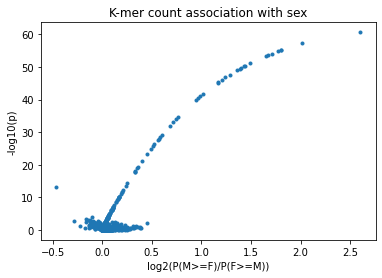

In [5]:
plt.plot(np.log2(effect_size_sex), -np.log10(pvals_sex), '.')
plt.xlabel('log2(P(M>=F)/P(F>=M))')
plt.ylabel('-log10(p)')
plt.title('K-mer count association with sex')



In [6]:
# Get pairings.
samples = bam_mappings.index
male_pairs = []
female_pairs = []
for f in set(bam_mappings.family):
    fam = bam_mappings[(bam_mappings.family==f) & (bam_mappings.relationship=='sibling')]
    affected_females = fam[(fam.sex_numeric=='2.0') & (fam.derived_affected_status=='autism')]
    affected_males = fam[(fam.sex_numeric=='1.0') & (fam.derived_affected_status=='autism')]
    unaffected_females = fam[(fam.sex_numeric=='2.0') & (pd.isna(fam.derived_affected_status))]
    unaffected_males = fam[(fam.sex_numeric=='1.0') & (pd.isna(fam.derived_affected_status))]
    
    male_pairs = affected_pairs + [(i,j) for i in affected_males.index for j in unaffected_males.index if ((i in samples) and (j in samples))]
    female_pairs = unaffected_pairs + [(i,j) for i in affected_females.index for j in unaffected_females.index if ((i in samples) and (j in samples))]
affecteds = [a for a,u in (male_pairs + female_pairs)]
unaffecteds = [u for a,u in (male_pairs + female_pairs)]    


pvals = np.zeros(1000000) + np.nan
effect_size = np.zeros(1000000) + np.nan
sig_covs_vcf = pd.DataFrame()
eps = 1e-20
mult = 1.0159 #6.37/6.27 #p.median(covs[males].values.flatten())/np.median(covs[females].values.flatten())
file = '/home/groups/dpwall/briannac/alt_haplotypes/data/kmers_unmapped_counts_filt.tsv'
for covs in pd.read_table(file, chunksize=1000, nrows=len(pvals), header=None, index_col=None):
    print(covs.index[0])
    covs.drop(0, inplace=True, axis=1)
    covs.columns = list(bam_mappings.index)
    covs_norm = covs[abs(covs[affecteds].values-covs[unaffecteds].values).sum(axis=1)>0]
    pvals[covs_norm.index] = [stats.wilcoxon(q[1][affecteds]+eps, q[1][unaffecteds]+eps, zero_method='pratt', alternative='greater').pvalue for q in covs_norm.iterrows()]
    effect_size[covs_norm.index] = [sum(q[1][affecteds].values >= q[1][unaffecteds].values)/sum(q[1][unaffecteds].values >= q[1][affecteds].values) for q in covs_norm.iterrows()]
    sig_covs_vcf = pd.concat([sig_covs_vcf, covs_norm[1-pvals[covs_norm.index]<(.05/10e6)]])

# Set up dataframe to save.    
pvals_asd = np.array([2*min(p, 1-p) for p in pvals])
idx = np.array([i for i,p in enumerate(pvals_asd) if ~np.isnan(p)])
effect_size_asd=np.array(effect_size)
effect_size_asd = effect_size_asd[~np.isnan(pvals_asd)]
pvals_asd = pvals_asd[~np.isnan(pvals_asd)]
df = pd.DataFrame([pvals_asd, effect_size_asd], columns=idx).transpose()
df.to_csv('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/pvals_asd/pvals_asd_%04d.tsv' % N_BATCH, sep='\t', header=None)
sig_covs_vcf.to_csv('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/sig_covs_asd/sig_covs_asd_%04d.tsv' % N_BATCH, sep='\t', header=None)

0
6
1000
15
2000
20
3000
24
4000
29
5000
34
6000
40
7000
50
8000
53
9000
57


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'K-mer count association with ASD')

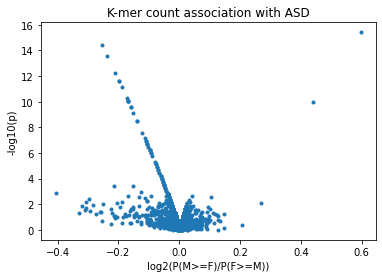

In [7]:
plt.plot(np.log2(effect_size_asd), -np.log10(pvals_asd), '.')
plt.xlabel('log2(P(M>=F)/P(F>=M))')
plt.ylabel('-log10(p)')
plt.title('K-mer count association with ASD')

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'K-mer count association with autism')

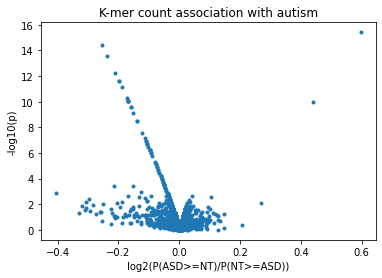

In [49]:
plt.plot(np.log2(effect_size_asd), -np.log10(pvals_asd), '.')
plt.xlabel('log2(P(ASD>=NT)/P(NT>=ASD))')
plt.ylabel('-log10(p)')
plt.title('K-mer count association with autism')

In [11]:
pvals = np.zeros(10000) + np.nan
eps = 1e-20
mult = 1.0159 #6.37/6.27 #p.median(covs[males].values.flatten())/np.median(covs[females].values.flatten())
file = '/home/groups/dpwall/briannac/alt_haplotypes/data/kmers_unmapped_counts_filt.tsv'
for covs in pd.read_table(file, chunksize=1000, nrows=len(pvals), header=None, index_col=None):
    covs.drop(0, inplace=True, axis=1)
    covs.columns = list(bam_mappings.index)
    covs_norm = covs[abs(covs[males].values-covs[females].values).sum(axis=1)>0]
    pvals[covs.index] = [stats.wilcoxon(q[1][males]+eps, mult*q[1][females]+eps, zero_method='pratt', alternative='greater').pvalue for q in covs_norm.iterrows()]
    break
pvals_sex = np.array([2*min(p, 1-p) for p in pvals[:(covs.index[-1]+1)]])


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


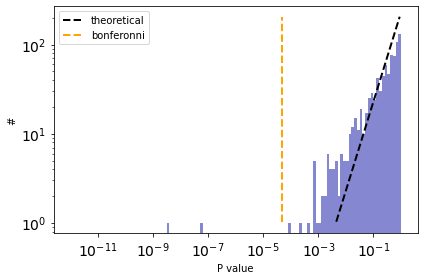

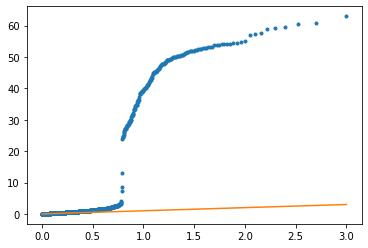

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


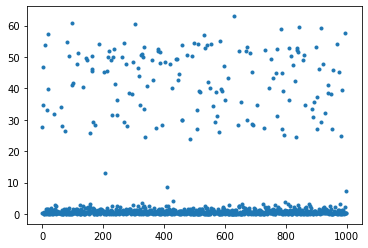

In [13]:
expected = np.arange(0,len(pvals_sex))/len(pvals_sex)
PlotPvals(pvals_sex)
plt.figure()
plt.plot(sorted(-np.log10(expected)), sorted(-np.log10(pvals_sex)), '.')
plt.plot(sorted(-np.log10(expected)), sorted(-np.log10(expected)), '-')
#plt.ylim(0,np.nanmax(-np.log10(expected[1:]))*)
plt.show()
plt.plot(-np.log10(pvals_sex), '.')
plt.show()

In [3]:
bam_mappings = pd.read_table('/home/groups/dpwall/briannac/general_data/bam_mappings.csv', index_col=1)
bam_mappings = bam_mappings[bam_mappings.status=='Passed_QC_analysis_ready']
bam_mappings = bam_mappings.drop('09C86428')

In [2]:
for kmers in pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/data/kmers_unmapped_filt.txt', 
                           chunksize=10000, header=None):
    break

In [4]:
# Get pairings.
samples = bam_mappings.index
male_pairs = []
female_pairs = []
for f in set(bam_mappings.family):
    fam = bam_mappings[(bam_mappings.family==f) & (bam_mappings.relationship=='sibling')].copy()
    affected_females = fam[(fam.sex_numeric=='2.0') & (fam.derived_affected_status=='autism')]
    affected_males = fam[(fam.sex_numeric=='1.0') & (fam.derived_affected_status=='autism')]
    unaffected_females = fam[(fam.sex_numeric=='2.0') & (pd.isna(fam.derived_affected_status))]
    unaffected_males = fam[(fam.sex_numeric=='1.0') & (pd.isna(fam.derived_affected_status))]
    male_pairs = male_pairs + [(i,j) for i in affected_males.index for j in unaffected_males.index if ((i in samples) and (j in samples))]
    female_pairs = female_pairs + [(i,j) for i in affected_females.index for j in unaffected_females.index if ((i in samples) and (j in samples))]
affected = [a for a,u in (male_pairs + female_pairs)]
unaffected = [u for a,u in (male_pairs + female_pairs)]

(array([ 26., 119., 172., 143.,  41.,   2.,   4.,   2.,   1.,   2.]),
 array([6.18995417e+08, 7.01925382e+08, 7.84855348e+08, 8.67785313e+08,
        9.50715278e+08, 1.03364524e+09, 1.11657521e+09, 1.19950517e+09,
        1.28243514e+09, 1.36536510e+09, 1.44829507e+09]),
 <BarContainer object of 10 artists>)

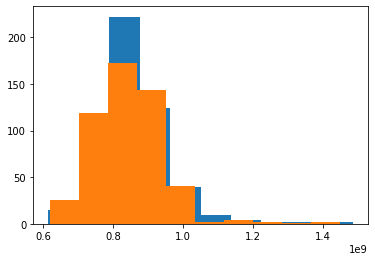

In [88]:
# Flagstat
flagstat = pd.read_csv('/home/groups/dpwall/briannac/general_data/ihart_flagstat.csv', index_col=0)
flagstat.index = [i.replace('-LCL', '_LCL') for i in flagstat.index]



plt.hist(flagstat.loc[affected].Total_Reads)
plt.hist(flagstat.loc[unaffected].Total_Reads)

In [86]:
stats.wilcoxon(flagstat.loc[affected].Total_Reads, flagstat.loc[unaffected].Total_Reads)

WilcoxonResult(statistic=55959.0, pvalue=0.0037597279845806367)

# Autism Association

# ASD vs NT Females

In [29]:
# Get pairings.
samples = bam_mappings.index
male_pairs = []
female_pairs = []
for f in set(bam_mappings.family):
    fam = bam_mappings[(bam_mappings.family==f) & (bam_mappings.relationship=='sibling')].copy()
    affected_females = fam[(fam.sex_numeric=='2.0') & (fam.derived_affected_status=='autism')]
    affected_males = fam[(fam.sex_numeric=='1.0') & (fam.derived_affected_status=='autism')]
    unaffected_females = fam[(fam.sex_numeric=='2.0') & (pd.isna(fam.derived_affected_status))]
    unaffected_males = fam[(fam.sex_numeric=='1.0') & (pd.isna(fam.derived_affected_status))]
    male_pairs = male_pairs + [(i,j) for i in affected_males.index for j in unaffected_males.index if ((i in samples) and (j in samples))]
    female_pairs = female_pairs + [(i,j) for i in affected_females.index for j in unaffected_females.index if ((i in samples) and (j in samples))]
affected = [a for a,u in (male_pairs + female_pairs)]
unaffected = [u for a,u in (male_pairs + female_pairs)]

In [75]:
pvals_autism = np.zeros(100000) + np.nan
eps = 1e-20
mult = 1.0159 #6.37/6.27 #p.median(covs[males].values.flatten())/np.median(covs[females].values.flatten())
file = '/home/groups/dpwall/briannac/alt_haplotypes/data/kmers_unmapped_counts_filt.tsv'
for covs in pd.read_table(file, chunksize=10000, nrows=len(pvals), header=None, index_col=None):
    covs.drop(0, inplace=True, axis=1)
    covs.columns = list(bam_mappings.index)
    print(covs.index[0])
    covs_norm = covs[abs(covs[affected].values-covs[unaffected].values).sum(axis=1)>0]
    covs_sum = covs_norm.sum()
    covs_norm = covs_norm.apply(lambda x: x/covs_sum, axis=1)
    pvals_autism[covs_norm.index] = [stats.wilcoxon(q[1][affected]+eps,  q[1][unaffected]+eps, zero_method='pratt', alternative='greater').pvalue for q in covs_norm.iterrows()]
pvals_autism = np.array([2*min(p, 1-p) for p in pvals_autism[:(covs.index[-1]+1)]])


0
10000
20000
30000
40000
50000
60000
70000
80000
90000


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


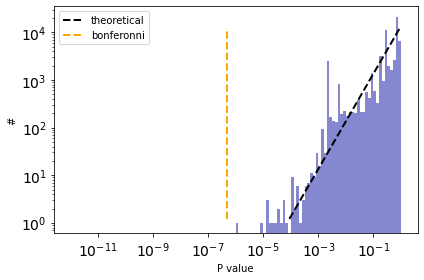

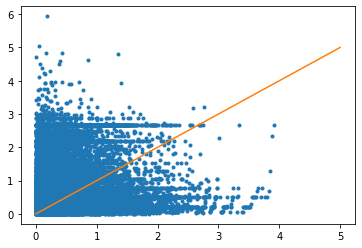

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


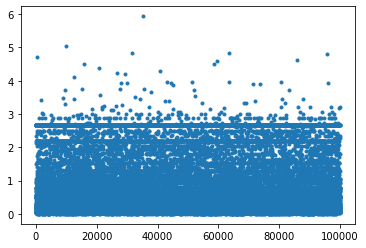

/home/users/briannac/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/users/briannac/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


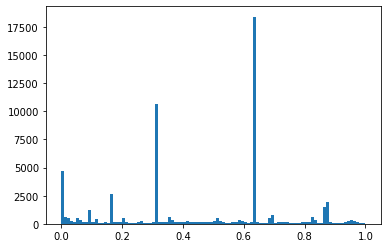

In [76]:
pvals_autism = np.array([2*min(p, 1-p) for p in pvals_autism[:(covs.index[-1]+1)]])

expected = np.arange(0,len(pvals_autism))/len(pvals_autism)
PlotPvals(pvals_autism)
plt.figure()
plt.plot(sorted(-np.log10(expected)), sorted(-np.log10(pvals_autism)), '.')
plt.plot(sorted(-np.log10(expected)), sorted(-np.log10(expected)), '-')
#plt.ylim(0,np.nanmax(-np.log10(expected[1:]))*)
plt.show()
plt.plot(-np.log10(pvals_autism), '.')
plt.show()


plt.hist(pvals_autism, bins=100)
plt.show()

## Matching concordant males.

In [41]:
# Matching affected w affected

# Get pairings.
samples = bam_mappings.index
male_pairs = []
female_pairs = []
for f in set(bam_mappings.family):
    fam = bam_mappings[(bam_mappings.family==f) & (bam_mappings.relationship=='sibling')].copy()
    affected_females = fam[(fam.sex_numeric=='2.0') & (fam.derived_affected_status=='autism')]
    affected_males = fam[(fam.sex_numeric=='1.0') & (fam.derived_affected_status=='autism')]
    unaffected_females = fam[(fam.sex_numeric=='2.0') & (pd.isna(fam.derived_affected_status))]
    unaffected_males = fam[(fam.sex_numeric=='1.0') & (pd.isna(fam.derived_affected_status))]
    male_pairs = male_pairs + [(i,j) for i in affected_males.index for j in affected_males.index if ((i in samples) and (j in samples) and (i<j))]
    female_pairs = female_pairs + [(i,j) for i in unaffected_males.index for j in unaffected_males.index if ((i in samples) and (j in samples) and (i<j))]
affected = [a for a,u in (male_pairs + female_pairs)]
unaffected = [u for a,u in (male_pairs + female_pairs)]

In [42]:
pvals = np.zeros(100000) + np.nan
eps = 1e-20
mult = 1.0159 #6.37/6.27 #p.median(covs[males].values.flatten())/np.median(covs[females].values.flatten())
file = '/home/groups/dpwall/briannac/alt_haplotypes/data/kmers_unmapped_prev_and_median_filt_counts.tsv'
for covs in pd.read_table(file, chunksize=10000, nrows=len(pvals), header=None, index_col=None):
    covs.drop(0, inplace=True, axis=1)
    covs.columns = list(bam_mappings.index)
    print(covs.index[0])
    #covs = covs.apply(lambda x: x * (1 + .0159*(bam_mappings.sex_numeric=='2.0').values), axis=1)
    #covs = covs[covs[affected+unaffected].sum(axis=1)>0]
    pvals[covs.index] = [stats.wilcoxon(q[1][affected]+eps, q[1][unaffected]+eps, zero_method='zsplit').pvalue for q in covs.iterrows()]
pvals_autism = pvals[:(covs.index[-1]+1)]

0
10000
20000


KeyboardInterrupt: 

In [48]:
pvals_autism = pvals[:(covs.index[-1]+1)]
pvals_autism = pvals_autism[~np.isnan(pvals_autism)]

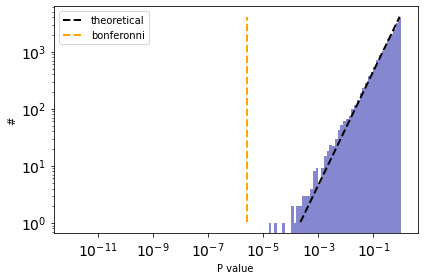

In [49]:
PlotPvals(pvals_autism)

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


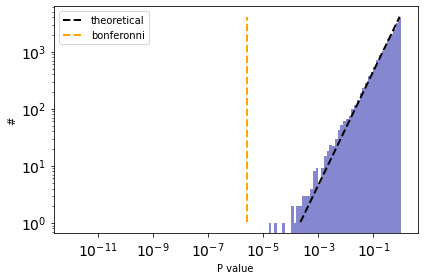

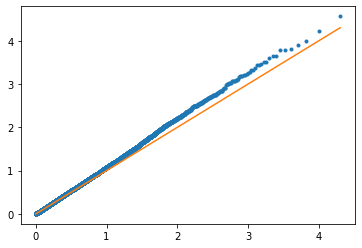

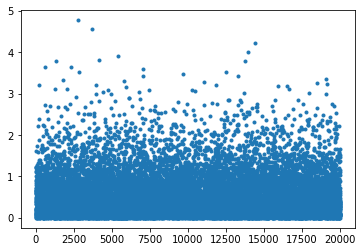

In [50]:
#pvals_autism = pvals_autism[~np.isnan(pvals_autism)]
expected = np.arange(0,len(pvals_autism))/len(pvals_autism)
PlotPvals(pvals_autism)
plt.figure()
plt.plot(sorted(-np.log10(expected)), sorted(-np.log10(pvals_autism)), '.')
plt.plot(sorted(-np.log10(expected)), sorted(-np.log10(expected)), '-')
#plt.ylim(0,np.nanmax(-np.log10(expected[1:]))*)
plt.show()
plt.plot(-np.log10(pvals_autism), '.')
plt.show()

# ASD vs NT Males test

In [283]:
# Get pairings.
samples = bam_mappings.index
male_pairs = []
female_pairs = []
for f in set(bam_mappings.family):
    fam = bam_mappings[(bam_mappings.family==f) & (bam_mappings.relationship=='sibling')].copy()
    affected_females = fam[(fam.sex_numeric=='2.0') & (fam.derived_affected_status=='autism')]
    affected_males = fam[(fam.sex_numeric=='1.0') & (fam.derived_affected_status=='autism')]
    unaffected_females = fam[(fam.sex_numeric=='2.0') & (pd.isna(fam.derived_affected_status))]
    unaffected_males = fam[(fam.sex_numeric=='1.0') & (pd.isna(fam.derived_affected_status))]
    male_pairs = male_pairs + [(i,j) for i in affected_males.index for j in unaffected_males.index if ((i in samples) and (j in samples))]
    female_pairs = female_pairs #+ [(i,j) for i in affected_females.index for j in unaffected_females.index if ((i in samples) and (j in samples))]
affected = [a for a,u in (male_pairs + female_pairs)]
unaffected = [u for a,u in (male_pairs + female_pairs)]

In [504]:
pvals = np.zeros(100000) + np.nan
fold_change = np.zeros(100000) + np.nan
eps = 0#1e-20
mult = 1.0159 #6.37/6.27 #p.median(covs[males].values.flatten())/np.median(covs[females].values.flatten())
file = '/home/groups/dpwall/briannac/alt_haplotypes/data/kmers_unmapped_prev_and_median_filt_counts.tsv'
for covs in pd.read_table(file, chunksize=10000, nrows=len(pvals), header=None, index_col=None):
    print(covs.index[0])
    covs.drop(0, inplace=True, axis=1)
    covs.columns = list(bam_mappings.index)
    if covs.index[0] == 0: covs_sum = covs.sum()
    else: covs_sum = covs.sum() + covs_sum
    pvals[covs.index] = [stats.wilcoxon(
        q[1][affected]/(flagstat.Total_Reads[affected]),
        q[1][unaffected]/(flagstat.Total_Reads[unaffected]), zero_method='zsplit').pvalue for q in covs.iterrows()]
    fold_change[covs.index] = np.log2(
        ((covs[affected]+.00001)/flagstat.Total_Reads[affected]).values/((covs[unaffected]+.00001)/flagstat.Total_Reads[unaffected]).values).mean(axis=1)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


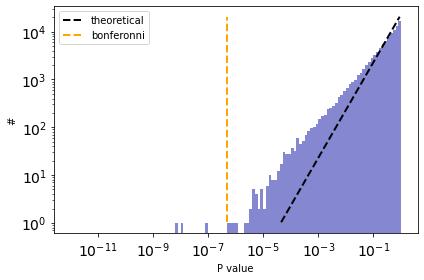

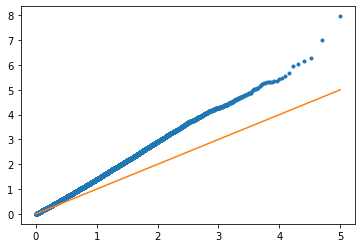

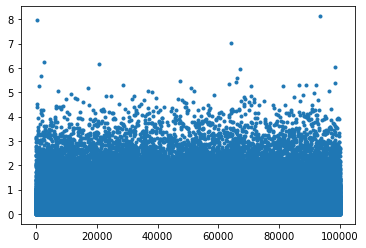

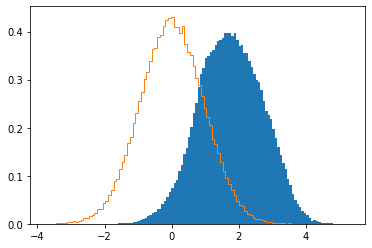

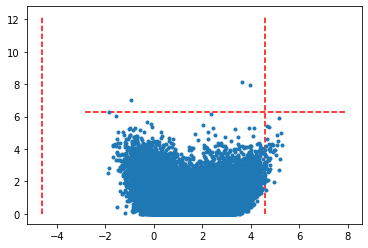

In [505]:
pvals_autism = pvals#[:(covs.index[-1]+1)]
pvals_autism = pvals_autism[~np.isnan(pvals_autism)]

fold_change_autism = fold_change#[:(covs.index[-1]+1)]
fold_change_autism = fold_change_autism[~np.isnan(fold_change_autism)]

expected = np.arange(0,len(pvals_autism))/len(pvals_autism)
PlotPvals(pvals_autism)
plt.figure()
plt.plot(sorted(-np.log10(expected)), sorted(-np.log10(pvals_autism)), '.')
plt.plot(sorted(-np.log10(expected)), sorted(-np.log10(expected)), '-')
#plt.ylim(0,np.nanmax(-np.log10(expected[1:]))*)
plt.show()
plt.plot(-np.log10(pvals_autism), '.')
plt.show()

plt.hist(fold_change_autism, bins=100, density=True)

rand = [0 + np.random.randn()*np.std(fold_change_autism) for i in range(len(fold_change_autism))]
plt.hist(rand, bins=100, histtype='step', density=True)

plt.show()

effect_size_sig_cutoff = abs(stats.norm.ppf((.05/len(fold_change_autism))))*np.std(fold_change_autism)
sig_effects = np.where(abs(fold_change_autism)>effect_size_sig_cutoff)[0]
p_value_cutoff = (.05/len(fold_change_autism))
plt.plot(fold_change_autism,-np.log10(pvals_autism),'.')
plt.hlines(y=-np.log10(p_value_cutoff), xmin=1.5*min(fold_change_autism), xmax=1.5*max(fold_change_autism),
           color='r', linestyles='dashed')

plt.vlines(x=-(effect_size_sig_cutoff), ymin=1.5*min(-np.log10(pvals_autism)), ymax=1.5*max(-np.log10(pvals_autism)), 
           color='r', linestyles='dashed')
plt.vlines(x=(effect_size_sig_cutoff), ymin=1.5*min(-np.log10(pvals_autism)), ymax=1.5*max(-np.log10(pvals_autism)),
           color='r', linestyles='dashed')

plt.show()


In [507]:
stats.wilcoxon((covs.sum()[affected].values)/flagstat.Total_Reads[affected],
               (covs.sum()[unaffected].values)/flagstat.Total_Reads[unaffected])

WilcoxonResult(statistic=33468.0, pvalue=0.4993797328148425)

In [510]:
np.argsort(pvals_autism)[:10]

array([93436,   347, 64261,  2827, 20698, 98307, 67226,  1691, 66150,
       47482])

# Exploring some significant examples

In [8]:
file = '/home/groups/dpwall/briannac/alt_haplotypes/data/kmers_unmapped_prev_and_median_filt_counts.tsv'

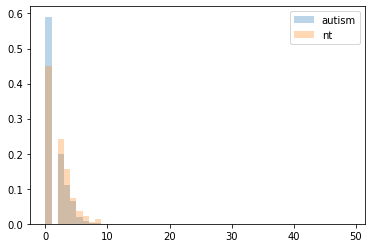

In [516]:
covs = pd.read_table(file,  nrows=1000, skiprows=98000, header=None, index_col=None)
covs.drop(0, inplace=True, axis=1)
covs.columns = list(bam_mappings.index)
plt.hist(covs[set(affected)].iloc[307].values.flatten(), bins=np.arange(0,50), alpha=.3, density=True, label='autism')
plt.hist(covs[set(unaffected)].iloc[307].values.flatten(), bins=np.arange(0,50), alpha=.3, density=True, label='nt')
plt.legend()
plt.show()

In [515]:
kmers = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/data/kmers_unmapped_prev_and_median_filt.txt', 
                           nrows=1000, skiprows=93000, header=None)
kmers.iloc[436].values

array(['CTCCTTTCCAAAGCACTGCACTCTACTCCACTCCACTACATTCCACTCCACTCCAATCCATTCTGTTCCATTGTATTCGATACCACTCTACTCAACCCTA'],
      dtype=object)